In [11]:
import scipy
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import pickle
from functools import partial

# from NeuralNet import *
from timeit import default_timer

from Solver import *
import sys
sys.path.append('../Utility')
import NeuralNet
import KalmanInversion 
from Numerics import interpolate_f2c, gradient_first_f2c
# import imp
# imp.reload(KalmanInversion )
# imp.reload(NeuralNet )


# Load Training data

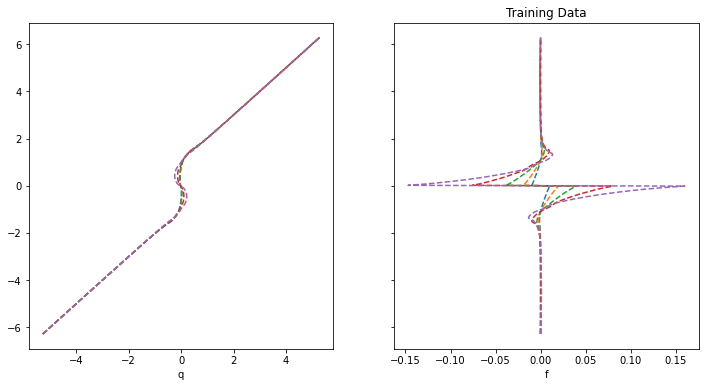

In [12]:
Nx = 384
beta = 1.0
tau_inv = [0.01, 0.02, 0.04, 0.08, 0.16]
N_data = len(tau_inv)

data_dirs = ["../data/beta_1.0_Gamma_1.0_relax_" + str(tau_inv[i]) + "/" for i in range(len(tau_inv))]

L = 4*np.pi
xx, closure_mean,  q_mean, dq_dx_mean = np.zeros((N_data,Nx)), np.zeros((N_data,Nx)), np.zeros((N_data,Nx)), np.zeros((N_data,Nx))
for i in range(N_data):  
    closure_mean[i, :], q_mean[i, :], dq_dx_mean[i, :] = load_data(data_dirs[i])
    xx[i, :] = np.linspace(-L/2.0, L/2.0, Nx)
dx = xx[0, 1] - xx[0, 0]


# TODO: clean data
omega_jet = np.zeros(Nx)
omega_jet[0:Nx//2] = 1.0
omega_jet[Nx//2:Nx] = -1.0
q_jet = omega_jet + beta*xx[0, :]


f = np.zeros(q_mean.shape)

chop_l = 50
for i in range(N_data):  
    q_mean[i, 0:chop_l] = np.linspace(q_jet[0],   q_mean[i,chop_l-1],  chop_l)   #q_jet[0:chop_l]
    q_mean[i, -chop_l:] = np.linspace(q_mean[i, -chop_l], q_jet[-1],  chop_l)   #q_jet[-chop_l:]
    
    
    dq_dx_mean[i, 0:chop_l] = np.linspace(beta, dq_dx_mean[i,chop_l-1],  chop_l)
    dq_dx_mean[i, -chop_l:] = np.linspace(dq_dx_mean[i, -chop_l], beta, chop_l)
    
    closure_mean[i, 0:chop_l] = np.linspace(0.0, closure_mean[i,chop_l-1],  chop_l)
    closure_mean[i, -chop_l:] = np.linspace(closure_mean[i, -chop_l], 0.0, chop_l)
    
    
    
    
    f[i, :] = tau_inv[i]*(q_jet - q_mean[i, :])

q_mean_abs = np.fabs(q_mean)
mu_f = closure_mean/dq_dx_mean
# visualize data

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(12,6))
for i in range(N_data):
    ax[0].plot(q_mean[i, :], xx[i,:],  "--", fillstyle="none", color="C"+str(i))
    ax[1].plot(f[i, :], xx[i,:],  "--", fillstyle="none", color="C"+str(i))
    
ax[0].set_xlabel("q")
ax[1].set_xlabel("f")   
plt.title("Training Data")
plt.savefig("Point-Jet-Training-Data.png")




# Training Loss : || d(D dq/dx)/dx + f(x)|| on the quadratic function

In [13]:
def loss_aug(s_param, params):
    xx, q = s_param.xx, s_param.q
    ind, outd, width = s_param.ind, s_param.outd, s_param.width
    activation, initializer, outputlayer = s_param.activation, s_param.initializer, s_param.outputlayer
    
    N_data, Nx = q.shape
    # does not include top and bottom nodes
    res = np.zeros((N_data, Nx - 2))
    

    net =  create_net(ind, outd, layers, width, activation, initializer, outputlayer,  params)
    
    nn_model = partial(nn_flux, net = net, non_negative=True)
    
    for i in range(N_data):
        nummodel(nn_model, q[i, :], xx[i, :], res[i, :])
        
    return np.hstack((-np.reshape(res, -1), params))


## Start UKI

In [14]:
class PointJetParam:
    def __init__(self, xx, q, N_y, ind, outd, layers, width, activation, initializer, outputlayer):
        self.theta_names = ["hyperparameters"]
        self.xx = xx
        self.q  = q
        self.ind  = ind
        self.outd = outd
        self.width = width
        self.activation = activation
        self.initializer = initializer
        self.outputlayer = outputlayer
        
        
        N_theta = ind*width + (layers - 2)*width**2 + width*outd + (layers - 1)*width + outd
        self.N_theta = N_theta
        
        
        self.N_y = N_y + N_theta 

In [22]:
y = np.reshape(f[:, 1:Nx - 1], -1)
Sigma_eta = np.fabs(f[:, 1:Nx - 1])
for i in range(N_data):
    Sigma_eta[i, :] = np.mean(Sigma_eta[i, :])
Sigma_eta = np.diag(np.reshape((Sigma_eta*0.01)**2, -1))


N_y = len(y)
ind, outd, width = 2, 1, 10
layers = 2
activation, initializer, outputlayer = "sigmoid", "default", "None"

s_param = PointJetParam(xx, q_mean, N_y,  ind, outd, layers, width, activation, initializer, outputlayer)


N_theta = s_param.N_theta


theta0_mean_init = NeuralNet.FNN(ind, outd, layers, width, activation, initializer, outputlayer).get_params()
# theta0_mean_init = torch.load("visc.model").get_params()
theta0_mean = np.zeros(N_theta)

theta0_cov = np.zeros((N_theta, N_theta))
np.fill_diagonal(theta0_cov, 100.0**2)  
theta0_cov_init = np.zeros((N_theta, N_theta))
np.fill_diagonal(theta0_cov_init, 1.0**2)  


y_aug = np.hstack((y, theta0_mean))
Sigma_eta_aug = block_diag(Sigma_eta, theta0_cov)


alpha_reg = 1.0
update_freq = 1
N_iter = 10
gamma = 1.0


save_folder = "indirect_NN_res"
uki_obj = KalmanInversion.UKI_Run(s_param, loss_aug, 
    theta0_mean, theta0_mean_init, 
    theta0_cov,  theta0_cov_init, 
    y_aug, Sigma_eta_aug,
    alpha_reg,
    gamma,
    update_freq, 
    N_iter,
    save_folder = save_folder)

ukiobj.gamma :  1.0
optimization error at iter  0  =  2065780412486.6562
data-misfit :  2065780412469.7756 reg :  16.88063792779944
Frobenius norm of the covariance at iter  0  =  6.4031242374328485
ukiobj.gamma :  1.0
optimization error at iter  1  =  80610179.68470971
data-misfit :  80610160.2893548 reg :  19.395354896709847
Frobenius norm of the covariance at iter  1  =  10.614440592181394
ukiobj.gamma :  1.0
optimization error at iter  2  =  61567855.840094276
data-misfit :  61567834.47554053 reg :  21.36455373525773
Frobenius norm of the covariance at iter  2  =  1.1561739807522242
ukiobj.gamma :  1.0
optimization error at iter  3  =  61106032.79753314
data-misfit :  61106009.25193247 reg :  23.545600662444414
Frobenius norm of the covariance at iter  3  =  1.8058324645066008
ukiobj.gamma :  2.0
optimization error at iter  4  =  61098346.87963071
data-misfit :  61098314.26664868 reg :  32.612982027223865
Frobenius norm of the covariance at iter  4  =  3.5506618882355916
ukiobj.gam

In [29]:
uki_obj = pickle.load( open( save_folder + "/ukiobj-" + str(8) + ".dat", "rb" ) )
#uki_obj = pickle.load( open( save_folder + "/ukiobj-" + str(N_iter-1) + ".dat", "rb" ) )

trained_net = create_net(ind, outd, layers, width, activation, initializer, outputlayer, uki_obj.theta_mean[-1])

print(trained_net.modus['LinM{}'.format(1)].weight)
print(trained_net.modus['LinM{}'.format(1)].bias)
print(trained_net.modus['LinMout'].weight)
print(trained_net.modus['LinMout'].bias)

Parameter containing:
tensor([[-454.2469,  661.4769],
        [  71.9082, -111.2707],
        [  97.0138,  177.4923],
        [  44.9797,   16.1627],
        [  71.1930,  209.4245],
        [ 313.4506,  380.4617],
        [  -8.8789, -373.7084],
        [-445.2956, -117.6265],
        [ -61.2305, -133.4385],
        [   5.5657,  -24.6962]], requires_grad=True)
Parameter containing:
tensor([-627.4543,   63.0294, -420.0373, -172.4177, -229.4051, -963.3331,
         169.4555,  800.8616,  222.1935,   20.9971], requires_grad=True)
Parameter containing:
tensor([[-3.3388e+01, -6.9005e-02, -3.1134e-01, -1.1744e-01,  5.8167e-02,
          8.8477e-02, -7.3210e+01,  1.2005e+02,  2.4690e-02, -9.1642e-02]],
       requires_grad=True)
Parameter containing:
tensor([-46.8687], requires_grad=True)


# Direct test

/central/home/dzhuang/Code/Point-Jet/Point_jet/Solver.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = net(torch.tensor(x, dtype=torch.float32)).detach().numpy().flatten() * mu_scale


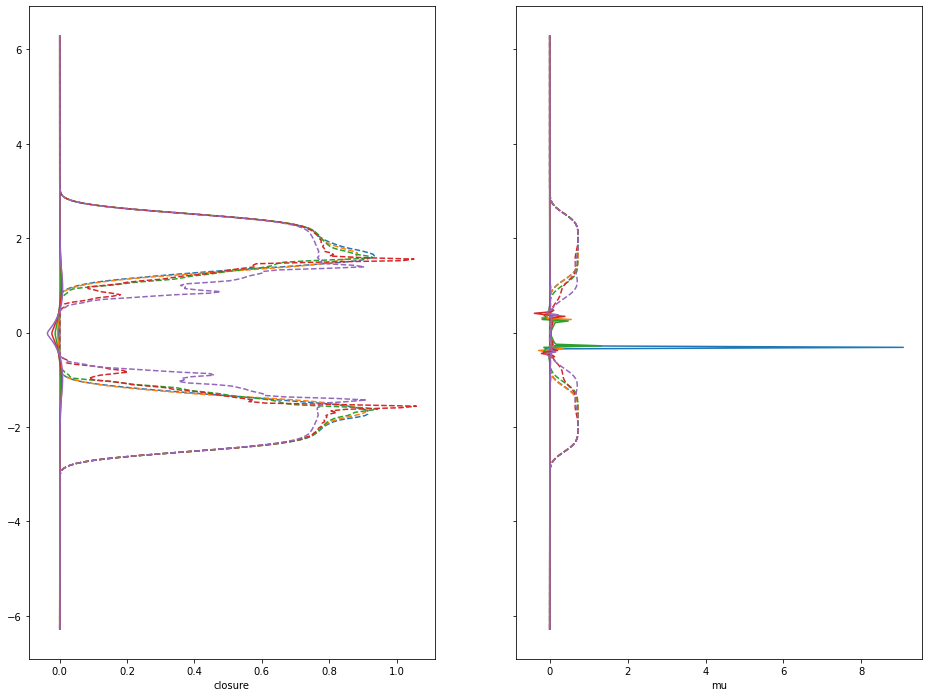

In [30]:
x_train = torch.from_numpy(np.stack((np.fabs(q_mean.flatten()), dq_dx_mean.flatten())).T.astype(np.float32)) 
y_pred = net_eval(x_train, trained_net, non_negative=True).reshape((N_data, Nx))

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(16,12))
for i in range(N_data):
    ax[0].plot(closure_mean[i,:], xx[i,:], color="C"+str(i))
    ax[0].plot(y_pred[i,:]*dq_dx_mean[i,:], xx[i,:], "--", color="C"+str(i))
    
    ax[1].plot(mu_f[i,:], xx[i,:], color="C"+str(i))
    ax[1].plot(y_pred[i,:], xx[i,:], "--", color="C"+str(i))
    
    ax[0].set_xlabel("closure")
    ax[1].set_xlabel("mu")
    

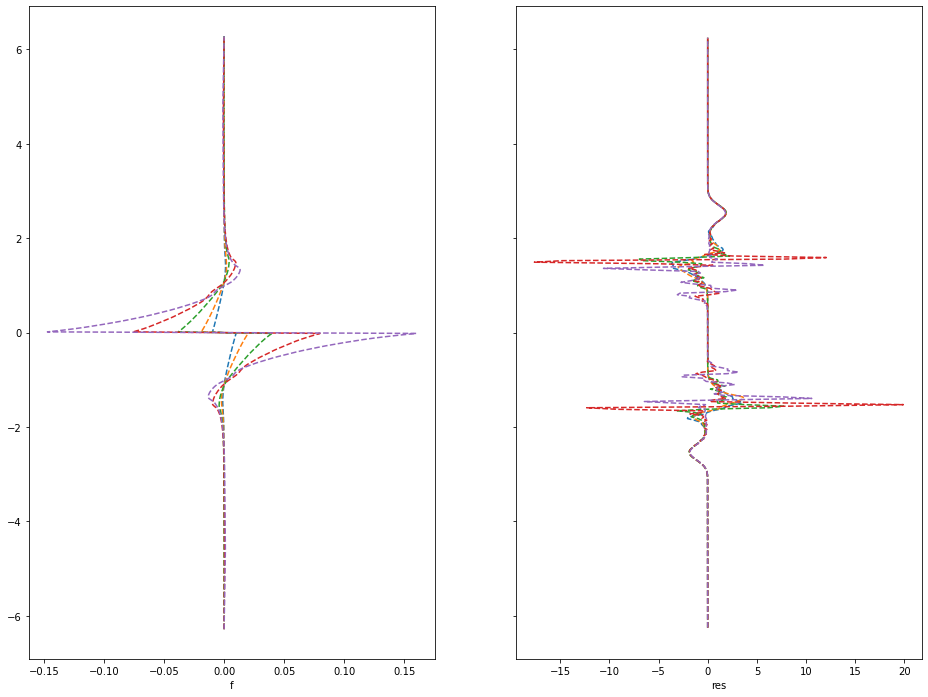

In [31]:
res = loss_aug(s_param, uki_obj.theta_mean[-1])[0:N_y].reshape((N_data,-1))


fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(16,12))
for i in range(N_data):
    ax[0].plot(f[i, :], xx[i,:],  "--", fillstyle="none", color="C"+str(i))
    
    #ax[0].plot(q_mean[i, :], xx[i,:],  "--", fillstyle="none", color="C"+str(i))
    ax[1].plot(res[i, :], xx[i, 1:-1],  "--", fillstyle="none", color="C"+str(i))
    
ax[0].set_xlabel("f")
ax[1].set_xlabel("res")   
plt.show()

# Plug-in test

1000 max q 5.283185307179586
2000 max q 5.283185307179586
3000 max q 5.283185307179586
4000 max q 5.283185307179586
5000 max q 5.283185307179586
6000 max q 5.283185307179586
7000 max q 5.283185307179586
8000 max q 5.283185307179586
9000 max q 5.283185307179586
10000 max q 5.283185307179586
11000 max q 5.283185307179586
12000 max q 5.283185307179586
13000 max q 5.283185307179586
14000 max q 5.283185307179586
15000 max q 5.283185307179586
16000 max q 5.283185307179586
17000 max q 5.283185307179586
18000 max q 5.283185307179586
19000 max q 5.283185307179586
20000 max q 5.283185307179586
21000 max q 5.283185307179586
22000 max q 5.283185307179586
23000 max q 5.283185307179586
24000 max q 5.283185307179586
25000 max q 5.283185307179586
26000 max q 5.283185307179586
27000 max q 5.283185307179586
28000 max q 5.283185307179586
29000 max q 5.283185307179586
30000 max q 5.283185307179586
31000 max q 5.283185307179586
32000 max q 5.283185307179586
33000 max q 5.283185307179586
34000 max q 5.28318

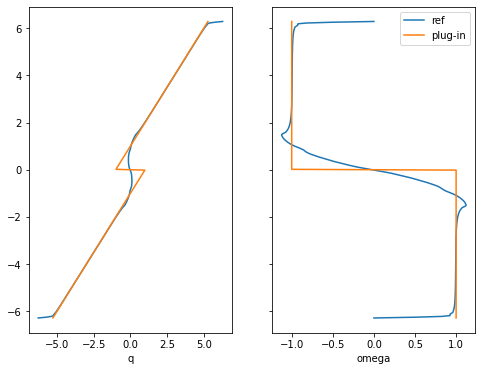

In [10]:
def point_jet(tau_inv, trained_net):

    beta = 1.0
    Nx = 384
    omega_jet = np.zeros(Nx)
    omega_jet[0:Nx//2] = 1.0
    omega_jet[Nx//2:Nx] = -1.0
    L = 4*np.pi
    yy = np.linspace(-L/2.0, L/2.0, Nx)
    q_jet = omega_jet + beta*yy



    tau = 1/float(tau_inv)
    data_dir = "../data/beta_1.0_Gamma_1.0_relax_" + tau_inv + "/"
    dq_dy = scipy.io.loadmat(data_dir+"data_dq_dy.mat")["data_dq_dy"]
    closure = scipy.io.loadmat(data_dir+"data_closure_cons.mat")["data_closure_cons"]
    w = scipy.io.loadmat(data_dir+"data_w.mat")["data_w"]
    q = scipy.io.loadmat(data_dir+"data_q.mat")["data_q"]

    _, Ny, Nt = q.shape
    q_mean_ref = np.mean(q[0, :, Nt//2:], axis=1)
    w_mean_ref = np.mean(w[0, :, Nt//2:], axis=1)



    nn_model = partial(nn_flux, net=trained_net, non_negative=True)
    model = lambda q, yy, res : nummodel_flux(nn_model, q, yy, res)
    dt, Nt, save_every = 1.0e-4, 200000, 1000
    yy, t_pred, q_pred = explicit_solve(model, q_jet, tau, dt, Nt, save_every, L = 4*np.pi)
    q_mean_pred = np.mean(q_pred[Nt//(2*save_every):, :], axis=0)
    
    
    return yy, q_mean_ref, q_mean_pred

yy, q_mean_ref, q_mean_pred = point_jet( "0.08" , trained_net)
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(8,6))


ax[0].plot(q_mean_ref, yy,   label="ref")                                                                         
ax[0].plot(q_mean_pred, yy, label="plug-in")
ax[1].plot(q_mean_ref  - beta*yy, yy,   label="ref")                                                                         
ax[1].plot(q_mean_pred - beta*yy, yy, label="plug-in")
ax[0].set_xlabel("q")
ax[1].set_xlabel("omega")
                                                                                                            
plt.legend()
plt.show()